#### imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt



In [2]:
##### Segmentation model

from transformers import pipeline
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)


/media/pixis/pixis/tausif_workspace/miniconda3/envs/any/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def initialize_video_capture(video_file_path):
    vc = cv2.VideoCapture(video_file_path)
    ret, first_frame = vc.read()
    if not ret:
        raise ValueError("Error: Could not read the first frame.")
    return vc, first_frame

def initialize_video_writer(vc, final_path, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = vc.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(final_path, fourcc, fps, frame_size)
    if not out.isOpened():
        raise ValueError("Error: VideoWriter did not open.")
    return out

def get_segmented_gray_frame(frame, resize_dim):
    image_pil = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_pil)
    pillow_image = pipe(image_pil)  # applies mask on input and returns a pillow image
    image_np = np.array(pillow_image)
    frame_cv2 = image_np[:, :, ::-1]
    seg_gray = cv2.cvtColor(frame_cv2, cv2.COLOR_BGR2GRAY)
    seg_gray = cv2.resize(seg_gray, (resize_dim[0], resize_dim[1]))
    return seg_gray

def initialize_display(resize_dim):
    plt.ion()
    fig, ax = plt.subplots()
    img_display = ax.imshow(np.zeros((resize_dim[0], resize_dim[1], 3), dtype=np.uint8))
    plt.title("Dense Optical Flow")
    return fig, ax, img_display

def calculate_optical_flow_magnitude(prev_gray, seg_gray):
    flow = cv2.calcOpticalFlowFarneback(prev_gray, seg_gray, None, pyr_scale=0.5, levels=5, winsize=11, iterations=5, poly_n=5, poly_sigma=1.1, flags=0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return magnitude, angle

def create_dense_flow_visual(frame, magnitude, angle, mask):
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    dense_flow = cv2.addWeighted(frame, 1, rgb, 2, 0)
    return dense_flow

def update_display(img_display, dense_flow):
    img_display.set_data(cv2.cvtColor(dense_flow, cv2.COLOR_BGR2RGB))
    plt.pause(0.001)

def save_frame(out, dense_flow):
    out.write(dense_flow)

def release_resources(vc, out, fig):
    vc.release()
    out.release()
    plt.ioff()
    plt.close(fig)


#### 1] Farneback Method

In [11]:

# Global variables
vid_save_path = "./butterworth-filtered-videos/optical-flow-vids"
resize_dim = 600
THRESH_MAGN = 50


def process_video(video_file_path):
    max_magnitude = 0
    valid_movement = True
    frame_counter = 0
    fname = video_file_path.split("/")[-1]

    ensure_directory_exists(vid_save_path)
    final_path = os.path.join(vid_save_path, fname)

    vc, first_frame = initialize_video_capture(video_file_path)
    H, W, c = first_frame.shape
    width, height = W//3, H//3
    out = initialize_video_writer(vc, final_path, (width, height))

    first_frame_resized = cv2.resize(first_frame, (width, height))
    prev_gray = get_segmented_gray_frame(first_frame_resized, (width, height))

    mask = np.zeros_like(first_frame_resized)
    mask[..., 1] = 255

    fig, ax, img_display = initialize_display((width, height))

    while vc.isOpened():
        frame_counter += 1
        ret, frame = vc.read()
        
        if not ret:
            print("All frames processed!")
            break
        
        frame_resized = cv2.resize(frame, (width, height))
        seg_gray = get_segmented_gray_frame(frame_resized, (width, height))

        magnitude, angle = calculate_optical_flow_magnitude(prev_gray, seg_gray)

        if np.any(np.isinf(magnitude)) or np.any(np.isnan(magnitude)):
            valid_movement = False
        
        dense_flow = create_dense_flow_visual(frame_resized, magnitude, angle, mask)
        if False:
            update_display(img_display, dense_flow)
        save_frame(out, dense_flow)

        prev_gray = seg_gray

        max_magnitude_temp = np.max(magnitude)
        if max_magnitude_temp > THRESH_MAGN:
            valid_movement = False
            max_magnitude = max_magnitude_temp
        else:
            max_magnitude = max(max_magnitude, max_magnitude_temp)

    release_resources(vc, out, fig)

    return max_magnitude, valid_movement
#

In [12]:

max_magnitude, valid_movement = process_video('./butterworth-filtered-videos/all_dataset/85f4265d-855_video_M_mat_butter_low_pass.mp4')
print(f"Max magnitude: {max_magnitude}, Valid movement: {valid_movement}")


All frames processed!
Max magnitude: 6.708174705505371, Valid movement: True


All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!


/tmp/ipykernel_155675/1677312702.py:44: RuntimeWarning: invalid value encountered in cast
  mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)


All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames

KeyboardInterrupt: 

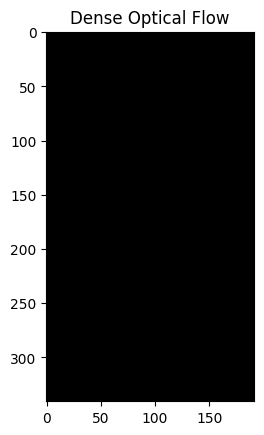

In [14]:
video_analysis_df = pd.DataFrame({})

def get_abs_vid_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "video_M_mat_butter_low_pass.mp4" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

vid_file_list = get_abs_vid_file_paths("./butterworth-filtered-videos/all_dataset")

for video_file_path in vid_file_list:
        max_magnitude, valid_movement = process_video(video_file_path)
        result_dict = {
                "video_file_path" : video_file_path,
                "valid_movement" : valid_movement,
                "max_magnitude" : max_magnitude
                }
        row = pd.DataFrame(result_dict, index = [0])
        video_analysis_df = pd.concat([video_analysis_df, row])

In [17]:
video_analysis_df.to_csv("./farneback_method.csv")

In [13]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assuming the following functions and variables are defined elsewhere:
# process_video(video_file_path)
# vid_file_list

video_analysis_df = pd.DataFrame({})

def get_abs_vid_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "video_M_mat_butter_low_pass.mp4" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

vid_file_list = get_abs_vid_file_paths("./butterworth-filtered-videos/all_dataset")


def analyze_video(video_file_path):
    max_magnitude, valid_movement = process_video(video_file_path)
    return {
        "video_file_path": video_file_path,
        "valid_movement": valid_movement,
        "max_magnitude": max_magnitude
    }

video_analysis_df = pd.DataFrame()

with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(analyze_video, video_file_path): video_file_path for video_file_path in vid_file_list}
    for future in as_completed(futures):
        result_dict = future.result()
        row = pd.DataFrame(result_dict, index=[0])
        video_analysis_df = pd.concat([video_analysis_df, row], ignore_index=True)

# Now video_analysis_df contains the results of all processed videos


/tmp/ipykernel_155675/1677312702.py:44: RuntimeWarning: invalid value encountered in cast
  mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)


All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames processed!
All frames

### misce : Copy required dataset 

In [5]:
import uuid
import shutil

In [6]:
def get_abs_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".jpg") and "frame_" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

def copy_to_dest(src_path, dest):
    idx = str(uuid.uuid4())
    file_name = src_path.split("/")[-1]
    destination_path = os.path.join(dest, idx[:12] + "_" + file_name)
    shutil.copy(src_path, destination_path)


In [7]:
root_dir = "../Data/"
test_sample_paths = get_abs_file_paths(root_dir)

In [17]:
# dest = "./org_frames_dataset/"
# for src in test_sample_paths:
#     copy_to_dest(src, dest)


### Copy all the video files to 

In [10]:
def get_abs_vid_file_paths(root_dir):
    all_files = []
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "video_M_mat_butter_low_pass.mp4" in filename:
                all_files.append(os.path.join(dirpath, filename))
    return all_files

video_files = get_abs_vid_file_paths(root_dir)

# vid_dest = "./butterworth-filtered-videos/all_dataset"
# for files in video_files:
#     copy_to_dest(files, vid_dest)

## *Trying Segmentation*

In [8]:
from transformers import pipeline

In [11]:
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)

### get images from dir 
org_imgs = get_abs_file_paths("./img-seg-data/org_frames_dataset")

In [13]:
for image_path in org_imgs:
    image_name = image_path.split("/")[-1]
    pillow_image = pipe(image_path) # applies mask on input and returns a pillow image
    pillow_image = pillow_image.convert("RGB")
    masked_img_path = os.path.join("./img-seg-data/segmented_images", image_name)
    pillow_image.save(masked_img_path)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


UnidentifiedImageError: cannot identify image file './img-seg-data/org_frames_dataset/adcf08d5-be9._frame_0003.jpg'

In [28]:


import cv2
import numpy as np

# Get a VideoCapture object from video and store it in vs
vc = cv2.VideoCapture("./butterworth-filtered-videos/all_dataset/0afaa9c4-702_video_M_mat_butter_low_pass.mp4")
# Read first frame
ret, first_frame = vc.read()
# Scale and resize image
resize_dim = 600
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale)
# Convert to gray scale 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)


# Create mask
mask = np.zeros_like(first_frame)
# Sets image saturation to maximum
mask[..., 1] = 255


out = cv2.VideoWriter('./video.mp4',-1,1,(600, 600))

while(vc.isOpened()):
    # Read a frame from video
    ret, frame = vc.read()
    
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)

    # Calculate dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Set image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    # Resize frame size to match dimensions
    frame = cv2.resize(frame, None, fx=scale, fy=scale)
    
    # Open a new window and displays the output frame
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
    cv2.imshow("Dense optical flow", dense_flow)
    out.write(dense_flow)
    # Update previous frame
    prev_gray = gray
    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
vc.release()

cv2.destroyAllWindows()


# In[ ]:





OpenCV: FFMPEG: format mp4 / MP4 (MPEG-4 Part 14)

(python:25673): GStreamer-CRITICAL **: 18:32:31.882: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@2908.650] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (2067) open OpenCV | GStreamer warning: OpenCV backend does not support passed FOURCC value
[ WARN:0@2908.650] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (1813) close_ OpenCV | GStreamer warning: No source in GStreamer pipeline. Ignore


fourcc tag 0x7634706d/'mp4v' codec_id 000C
fourcc tag 0x31637661/'avc1' codec_id 001B
fourcc tag 0x33637661/'avc3' codec_id 001B
fourcc tag 0x31766568/'hev1' codec_id 00AD
fourcc tag 0x31637668/'hvc1' codec_id 00AD
fourcc tag 0x7634706d/'mp4v' codec_id 0002
fourcc tag 0x7634706d/'mp4v' codec_id 0001
fourcc tag 0x7634706d/'mp4v' codec_id 0007
fourcc tag 0x7634706d/'mp4v' codec_id 003D
fourcc tag 0x7634706d/'mp4v' codec_id 0058
fourcc tag 0x312d6376/'vc-1' codec_id 0046
fourcc tag 0x63617264/'drac' codec_id 0074
fourcc tag 0x7634706d/'mp4v' codec_id 00A3
fourcc tag 0x39307076/'vp09' codec_id 00A7
fourcc tag 0x31307661/'av01' codec_id 801D
fourcc tag 0x6134706d/'mp4a' codec_id 15002
fourcc tag 0x6134706d/'mp4a' codec_id 1502D
fourcc tag 0x6134706d/'mp4a' codec_id 15001
fourcc tag 0x6134706d/'mp4a' codec_id 15000
fourcc tag 0x332d6361/'ac-3' codec_id 15003
fourcc tag 0x332d6365/'ec-3' codec_id 15028
fourcc tag 0x6134706d/'mp4a' codec_id 15004
fourcc tag 0x43614c66/'fLaC' codec_id 1500C
fou

/tmp/ipykernel_25673/1212622767.py:41: RuntimeWarning: invalid value encountered in cast
  mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)


error: OpenCV(4.6.0) /croot/opencv-suite_1691620365762/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
